Name: Karthik Venugopal

USC ID: 9330529336

github username: Karthikvenugopal

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
import os

In [2]:
base_dir = "SeparatedWaste"
dirs = {split: os.path.join(base_dir, split) for split in ["train", "val", "test"]}

img_size = (224, 224)
batch_size = 5

preprocess_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_gen = preprocess_gen.flow_from_directory(
    dirs["train"], target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True
)
val_gen = preprocess_gen.flow_from_directory(
    dirs["val"], target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_gen = preprocess_gen.flow_from_directory(
    dirs["test"], target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

Found 3323 images belonging to 9 classes.
Found 710 images belonging to 9 classes.
Found 719 images belonging to 9 classes.


In [3]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*img_size, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True
)
epochs = 100
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


665/665 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.2107 - loss: 9.1757 - val_accuracy: 0.4521 - val_loss: 8.2442
Epoch 2/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 45s 68ms/step - accuracy: 0.4195 - loss: 8.2808 - val_accuracy: 0.5732 - val_loss: 7.6921
Epoch 3/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 45s 67ms/step - accuracy: 0.5207 - loss: 7.8126 - val_accuracy: 0.6155 - val_loss: 7.3301
Epoch 4/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.5651 - loss: 7.4776 - val_accuracy: 0.6775 - val_loss: 6.9502
Epoch 5/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.6081 - loss: 7.1395 - val_accuracy: 0.7085 - val_loss: 6.6353
Epoch 6/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - accuracy: 0.6161 - loss: 6.8553 - val_accuracy: 0.7169 - val_loss: 6.3696
Epoch 7/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.6152 - loss: 6.6266 - val_accuracy: 0.7408 - val_loss: 6.0747
Epoch 8/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - accuracy: 0.6743 - loss: 6.2474 - val_

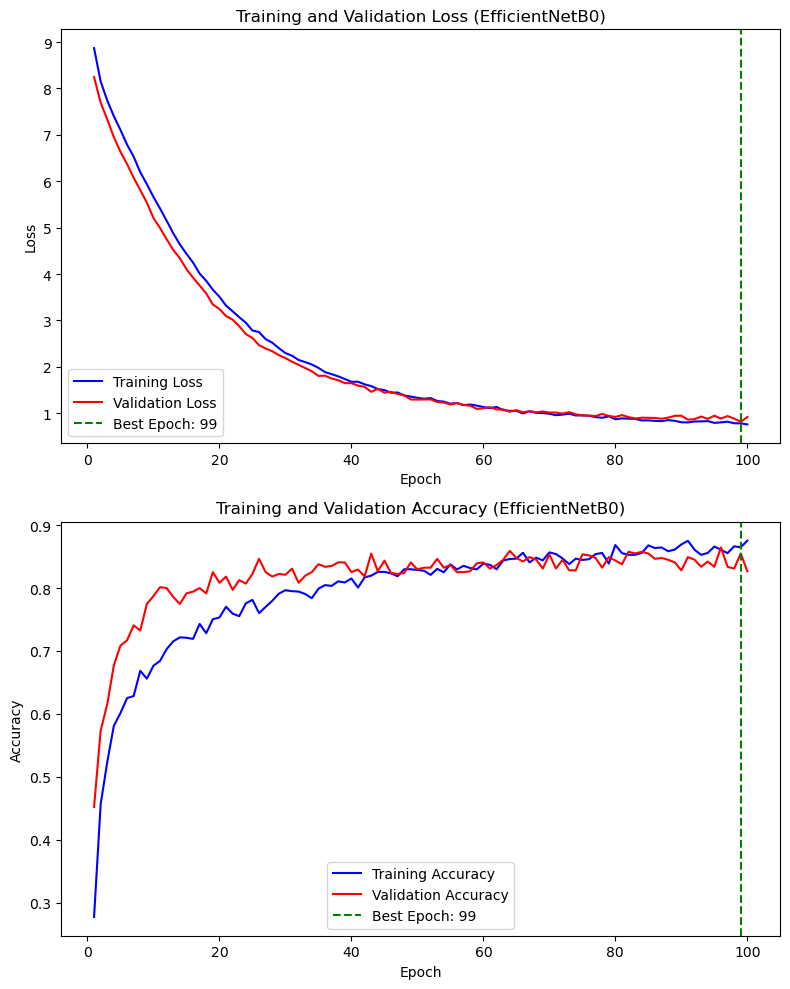

In [5]:
history_df = pd.DataFrame(history.history)
epoch_range = np.arange(1, len(history_df) + 1)
best_epoch = history_df['val_loss'].idxmin() + 1

fig, axes = plt.subplots(2, 1, figsize=(8, 10))

axes[0].plot(epoch_range, history_df['loss'], 'b', label='Training Loss')
axes[0].plot(epoch_range, history_df['val_loss'], 'r', label='Validation Loss')
axes[0].axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch: {best_epoch}')
axes[0].set_title('Training and Validation Loss (EfficientNetB0)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epoch_range, history_df['accuracy'], 'b', label='Training Accuracy')
axes[1].plot(epoch_range, history_df['val_accuracy'], 'r', label='Validation Accuracy')
axes[1].axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch: {best_epoch}')
axes[1].set_title('Training and Validation Accuracy (EfficientNetB0)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [6]:
y_test_probs = model.predict(test_gen, verbose=0)
y_test_preds = np.argmax(y_test_probs, axis=1)
y_test_true = test_gen.classes

class_names = [f"{i+1}-{name}" for i, name in enumerate(test_gen.class_indices)]

report_dict = classification_report(
    y_test_true, y_test_preds, target_names=class_names, output_dict=True
)
report_df = pd.DataFrame(report_dict).T.round(2)

summary_rows = ['accuracy', 'macro avg', 'weighted avg']
class_rows = [row for row in report_df.index if row not in summary_rows]
report_df = report_df.loc[class_rows + summary_rows]

print("\nClassification Report for EfficientNetB0 on Test Set:\n")
print(report_df.to_string())

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Classification Report for EfficientNetB0 on Test Set:

                         precision  recall  f1-score  support
1-1-Cardboard                 0.86    0.84      0.85    70.00
2-2-Food Organics             0.87    0.98      0.93    63.00
3-3-Glass                     0.85    0.83      0.84    63.00
4-4-Metal                     0.84    0.91      0.87   119.00
5-5-Miscellaneous Trash       0.83    0.67      0.74    75.00
6-6-Paper                     0.87    0.89      0.88    75.00
7-7-Plastic                   0.80    0.84      0.82   139.00
8-8-Textile Trash             0.93    0.78      0.84    49.00
9-9-Vegetation                0.98    0.95      0.97    66.00
accuracy                      0.86    0.86      0.86     0.86
macro avg                     0.87    0.85      0.86   719.00
weighted avg                  0.86    0.86      0.86   719.00


In [7]:
model.save('Final_EfficientNetB0_model.keras')